## Introduction

This notebook will be where I find the best parameters on the models that performed best for Model1 (using T1, T2). I will do the final testing here as well.

In [1]:
# Load the necessary modules
# Relative paths (make sure you are in src)
import os, sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries 
import numpy as np 
import pandas as pd 

# My code
from data_processing import get_path
from Models.RandomForest import Random_Forest_ensemble
from Models.BaggingEnsemble import Bagging_Ensemble
from Models.Boosting import Boosting_Regressor
from utils import evaluate_regression_metrics
from data_processing import standarize_numerical_variables

# Machine learning libraries 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,StackingRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Parameters
import configparser
config = configparser.ConfigParser()
config.read('../configuration.ini')


['../configuration.ini']

In [2]:
# Import data from relative path for train
file = get_path('created_files','train',parent_dir)
data = pd.read_csv(file,sep = ',')
X_train_p = data.drop(columns=['T3']).reset_index(drop=True)
y_train_p = data['T3'].reset_index(drop=True)

# Do the train/ test split and standarize AFTER so there is no data leakage
X_train, X_test, y_train_unstd, y_test_unstd = train_test_split(X_train_p,y_train_p,test_size=0.2)
X_train, X_test, y_train,y_test,scaler_y = standarize_numerical_variables(X_train, X_test, y_train_unstd, y_test_unstd,1)

# Import data from relative path for test
file_test = get_path('created_files','test',parent_dir)
data_test = pd.read_csv(file_test,sep = ',')
X_test_final = data.drop(columns=['T3']).reset_index(drop=True)
y_test_final = data['T3'].reset_index(drop=True)

#### 1. Linear Regression

We saw in the other notebook that the linear regressor on itself has good performance. 

There are no parameters to fit in linear regression, however, I will try to fit the **stack** since it had good performance but seemed to be overfitted. I will try to search for the best parameters and try not to overfit using Grid search.

In [3]:
base_models = [
    ('lasso', LassoCV(cv=5)),
    ('RF', RandomForestRegressor(random_state=42)),
]
base_models1 = [
    ('RF', RandomForestRegressor(random_state=42)),
    ('svm', SVR(C=1.0, epsilon=0.2))
]

base_models_2 = [
    ('gbr', GradientBoostingRegressor(n_estimators=50,max_features=0.8,subsample=0.9,random_state=42)),
    ('RF', RandomForestRegressor(random_state=42,n_estimators=100,max_features=0.8) ),
    ('bag', BaggingRegressor(random_state=42,n_estimators=100)),
    ('svr', SVR(C=1, gamma='scale',kernel='linear'))
]

base_models_3 = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('knn', KNeighborsRegressor(n_neighbors=5))
]

base_models_4 = [
    ('gbr', GradientBoostingRegressor(n_estimators=50,max_features=0.8,subsample=0.9,random_state=42)),
    ('RF', RandomForestRegressor(random_state=42,n_estimators=100,max_features=0.8) ),
    ('bag', BaggingRegressor(random_state=42,n_estimators=100))
]

pipe = Pipeline([
    ('stack', StackingRegressor(estimators=base_models, final_estimator=LinearRegression(),cv=5,passthrough=True,n_jobs=-1)),
])

param_grid = {
    'stack__final_estimator': [LinearRegression(), LassoCV()],
    'stack__estimators': [base_models,base_models1,base_models_2,base_models_3,base_models_4]
}
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train_unstd)

y_pred = grid_search.predict(X_test)
y_pred_t = grid_search.predict(X_train)


print("Best parameters found:", grid_search.best_params_)
print("Best score (CV):", grid_search.best_score_)

results = evaluate_regression_metrics(y_test_unstd, y_train_unstd, y_pred, y_pred_t)
print(results)


Best parameters found: {'stack__estimators': [('gbr', GradientBoostingRegressor(max_features=0.8, n_estimators=50, random_state=42,
                          subsample=0.9)), ('RF', RandomForestRegressor(max_features=0.8, random_state=42)), ('bag', BaggingRegressor(n_estimators=100, random_state=42))], 'stack__final_estimator': LassoCV()}
Best score (CV): 0.865486702300962
{'Mean Absolute Error:': 0.8629110652392971, 'Mean Squared Error:': 2.323091990388733, 'R² Score Test:': 0.865213900948345, 'R² Score Train:': 0.966482194843339}


#### 2. Random Forest

Optimal value of k manual: 100 with a score of 0.8758662964033823
Optimal value of k sklearn: 100 with a score of 0.8874714650007584


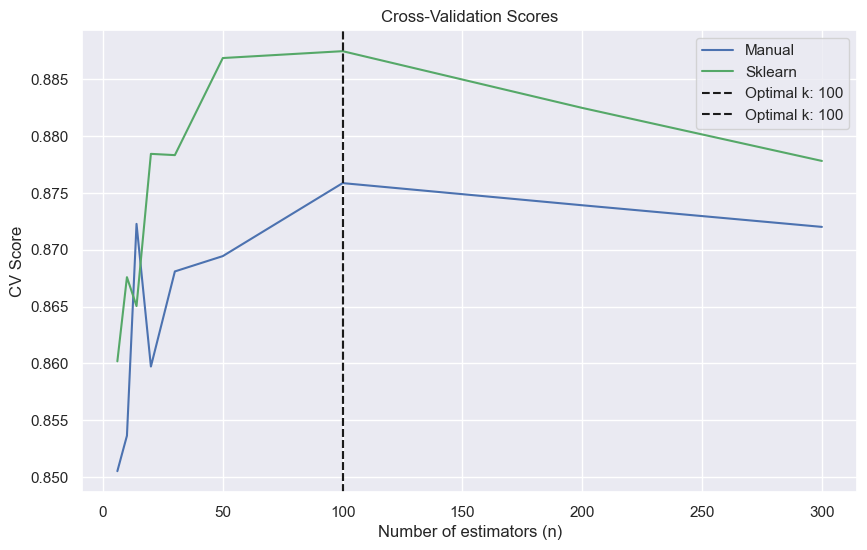

In [9]:
max_samples = 0.8
tipo = 'reg'
max_features = 0.8
manual = []
sklearnn = []
n_est = [6,10,14,20,30,50,100,200,300]

for n_estimators in n_est:

    rf = Random_Forest_ensemble(tipo = 'reg') 
    rf.fit(X_train,X_test, y_train_unstd,n_estimators=n_estimators,max_samples=max_samples,max_features=max_features)
    rf_pred = rf.predict()
    score = rf.score(y_test_unstd,y_train_unstd)
    manual.append(score['R² Score Test:'])

    rf = RandomForestRegressor(random_state=0,n_estimators=n_estimators,max_features=max_features) 
    rf.fit(X_train, y_train_unstd)
    rf_pred = rf.predict(X_test)
    rf_pred_train = rf.predict(X_train)
    score = evaluate_regression_metrics(y_test_unstd,y_train_unstd,rf_pred,rf_pred_train)
    sklearnn.append(score['R² Score Test:'])

highest_score_manual = np.argmax(manual)
optimal_k_manual = n_est[highest_score_manual]

highest_score_sk = np.argmax(sklearnn)
optimal_k_sk = n_est[highest_score_sk]

print(f"Optimal value of n manual: {optimal_k_manual} with a score of {manual[highest_score_manual]}")
print(f"Optimal value of n sklearn: {optimal_k_sk} with a score of {sklearnn[highest_score_sk]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_est,manual,'b',label= 'Manual')
plt.plot(n_est,sklearnn,'g',label='Sklearn')
plt.axvline(x=optimal_k_manual, linestyle='--', color='k', label=f'Optimal k: {optimal_k_manual}')
plt.axvline(x=optimal_k_sk, linestyle='--', color='k', label=f'Optimal k: {optimal_k_sk}')

plt.title('Cross-Validation Scores')
plt.xlabel('Number of estimators (n)')
plt.ylabel('CV Score')
plt.legend()
plt.grid(True)
plt.show()
    

Optimal value of mf manual: 0.9 with a score of 0.8793763173891818
Optimal value of mf sklearn: 0.8 with a score of 0.8824802783847452


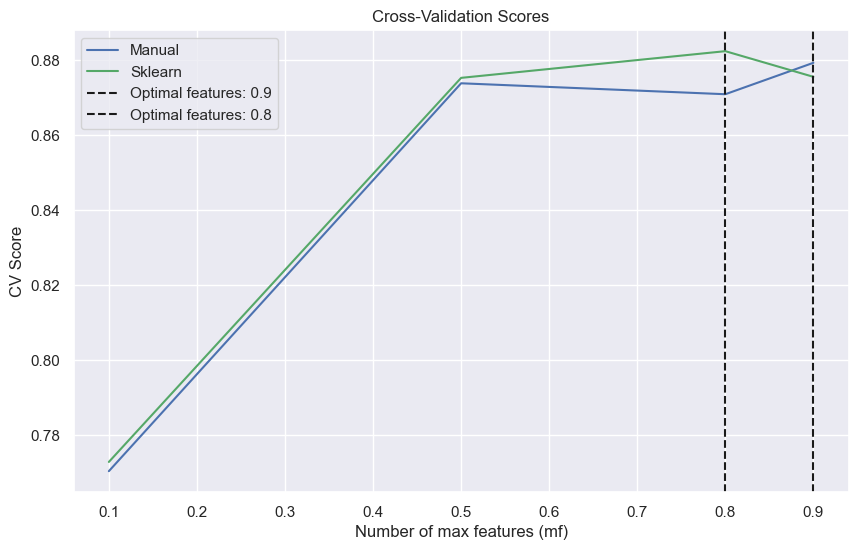

In [ ]:
max_samples = 0.8
tipo = 'reg'
max_featuress = [0.1,0.5,0.8,0.9]
manual = []
sklearnn = []
n_est = 100

for max_features in max_featuress:

    rf = Random_Forest_ensemble(tipo = 'reg') 
    rf.fit(X_train,X_test, y_train_unstd,n_estimators=n_estimators,max_samples=max_samples,max_features=max_features)
    rf_pred = rf.predict()
    score = rf.score(y_test_unstd,y_train_unstd)
    manual.append(score['R² Score Test:'])

    rf = RandomForestRegressor(random_state=0,n_estimators=n_estimators,max_features=max_features) 
    rf.fit(X_train, y_train_unstd)
    rf_pred = rf.predict(X_test)
    rf_pred_train = rf.predict(X_train)
    score = evaluate_regression_metrics(y_test_unstd,y_train_unstd,rf_pred,rf_pred_train)
    sklearnn.append(score['R² Score Test:'])

highest_score_manual = np.argmax(manual)
optimal_k_manual = max_featuress[highest_score_manual]

highest_score_sk = np.argmax(sklearnn)
optimal_k_sk = max_featuress[highest_score_sk]

print(f"Optimal value of mf manual: {optimal_k_manual} with a score of {manual[highest_score_manual]}")
print(f"Optimal value of mf sklearn: {optimal_k_sk} with a score of {sklearnn[highest_score_sk]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(max_featuress,manual,'b',label= 'Manual')
plt.plot(max_featuress,sklearnn,'g',label='Sklearn')
plt.axvline(x=optimal_k_manual, linestyle='--', color='k', label=f'Optimal features: {optimal_k_manual}')
plt.axvline(x=optimal_k_sk, linestyle='--', color='k', label=f'Optimal features: {optimal_k_sk}')

plt.title('Cross-Validation Scores')
plt.xlabel('Number of max features (mf)')
plt.ylabel('CV Score')
plt.legend()
plt.grid(True)
plt.show()
    

In [10]:
mRF = RandomForestRegressor(n_estimators=100)
mRF.fit(X_train,y_train)
y_pred = mRF.predict(X_test)
y_pred_train = mRF.predict(X_train)

print('Internal score: ',mRF.score(X_test,y_test))
print(evaluate_regression_metrics(y_test,y_train,y_pred,y_pred_train))


Internal score:  0.8691774230244198
{'Mean Absolute Error:': 0.21203928598891342, 'Mean Squared Error:': 0.12277258382415432, 'R² Score Test:': 0.8691774230244198, 'R² Score Train:': 0.9771939332481593}


<Axes: >

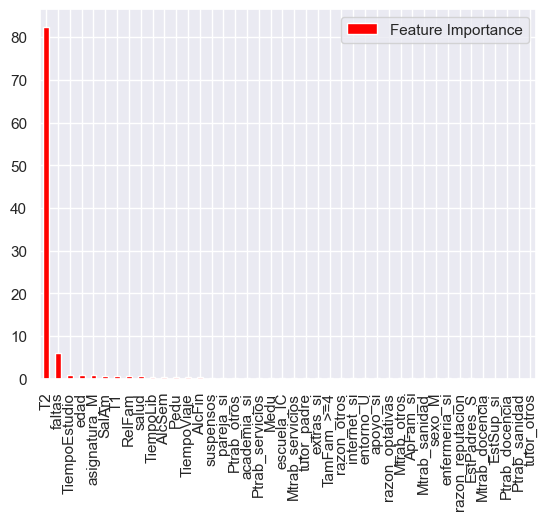

In [11]:
rf_featureImportance= pd.DataFrame({'Feature Importance':mRF.feature_importances_*100}, index= X_train.columns)
rf_featureImportance.sort_values('Feature Importance', ascending=False).plot(kind='bar', color='red')

#### 3. Bagging

Optimal value of n manual: 20 with a score of 0.877731803617473
Optimal value of n sklearn: 100 with a score of 0.8818652863358866


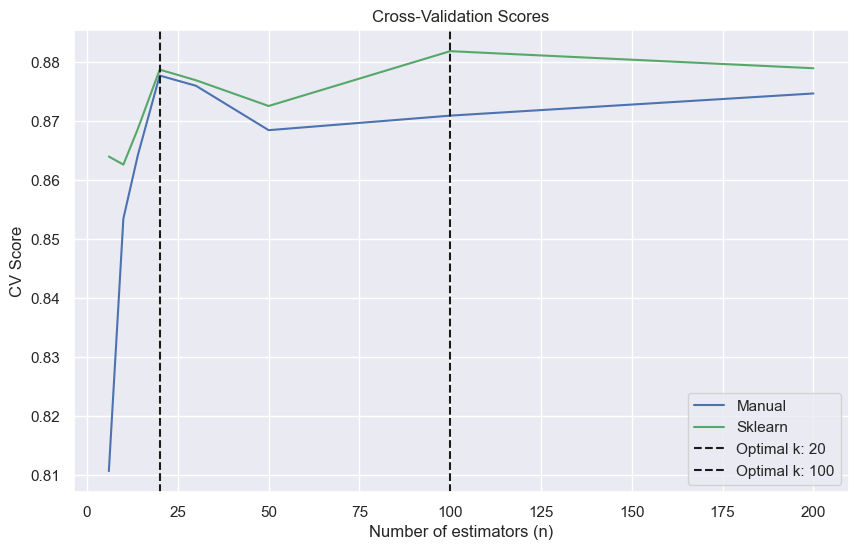

In [17]:

n_est = [6,10,14,20,30,50,100,200]
manual = []
sklearnn = []
max_samples = 0.8

for n_estimators in n_est:
    bagging = Bagging_Ensemble(tipo = 'reg') 
    bagging.fit(X_train,X_test, y_train_unstd,n_estimators=n_estimators,max_samples=max_samples)
    bagging_pred = bagging.predict()
    score = bagging.score(y_test_unstd,y_train_unstd)
    manual.append(score['R² Score Test:'])

    bagging = BaggingRegressor(random_state=0,n_estimators=n_estimators) 
    bagging.fit(X_train, y_train_unstd)
    bagging_pred = bagging.predict(X_test)
    bagging_pred_train = bagging.predict(X_train)
    score = evaluate_regression_metrics(y_test_unstd,y_train_unstd,bagging_pred,bagging_pred_train)
    sklearnn.append(score['R² Score Test:'])


highest_score_manual = np.argmax(manual)
optimal_k_manual = n_est[highest_score_manual]

highest_score_sk = np.argmax(sklearnn)
optimal_k_sk = n_est[highest_score_sk]

print(f"Optimal value of n manual: {optimal_k_manual} with a score of {manual[highest_score_manual]}")
print(f"Optimal value of n sklearn: {optimal_k_sk} with a score of {sklearnn[highest_score_sk]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_est,manual,'b',label= 'Manual')
plt.plot(n_est,sklearnn,'g',label='Sklearn')
plt.axvline(x=optimal_k_manual, linestyle='--', color='k', label=f'Optimal k: {optimal_k_manual}')
plt.axvline(x=optimal_k_sk, linestyle='--', color='k', label=f'Optimal k: {optimal_k_sk}')

plt.title('Cross-Validation Scores')
plt.xlabel('Number of estimators (n)')
plt.ylabel('CV Score')
plt.legend()
plt.grid(True)
plt.show()
    

#### 4. SVR

I already conducted cross validation on SVR in *Model1_Testing*, you can check it out there.

#### 5. Boosting

Optimal value of n manual: 20 with a score of 0.8629578314830242
Optimal value of n sklearn: 20 with a score of 0.8654098903256717


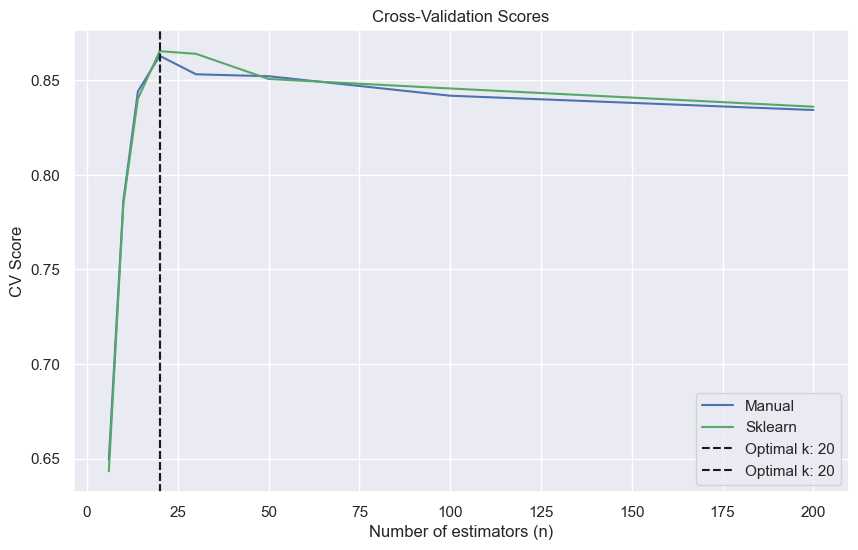

In [32]:
n_est = [6,10,14,20,30,50,100,200]
sklearnn = []
manual = []
max_samples = 0.8

for n_estimators in n_est:
    gb = Boosting_Regressor(n_estimators=n_estimators)
    gb.fit(X_train, y_train_unstd)
    gb_pred = gb.predict(X_test)
    gb_pred_train = gb.predict(X_train)
    score = evaluate_regression_metrics(y_test_unstd, y_train_unstd, gb_pred, gb_pred_train)
    manual.append(score['R² Score Test:'])

    gb = GradientBoostingRegressor(n_estimators=n_estimators,max_features=max_features,subsample=max_samples,random_state=0)
    gb.fit(X_train, y_train_unstd)
    gb_pred = gb.predict(X_test)
    gb_pred_train = gb.predict(X_train)
    score = evaluate_regression_metrics(y_test_unstd, y_train_unstd, gb_pred, gb_pred_train)
    sklearnn.append(score['R² Score Test:'])


highest_score_manual = np.argmax(manual)
optimal_k_manual = n_est[highest_score_manual]

highest_score_sk = np.argmax(sklearnn)
optimal_k_sk = n_est[highest_score_sk]

print(f"Optimal value of n manual: {optimal_k_manual} with a score of {manual[highest_score_manual]}")
print(f"Optimal value of n sklearn: {optimal_k_sk} with a score of {sklearnn[highest_score_sk]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_est,manual,'b',label= 'Manual')
plt.plot(n_est,sklearnn,'g',label='Sklearn')
plt.axvline(x=optimal_k_manual, linestyle='--', color='k', label=f'Optimal k: {optimal_k_manual}')
plt.axvline(x=optimal_k_sk, linestyle='--', color='k', label=f'Optimal k: {optimal_k_sk}')

plt.title('Cross-Validation Scores')
plt.xlabel('Number of estimators (n)')
plt.ylabel('CV Score')
plt.legend()
plt.grid(True)
plt.show()
    

Optimal value of mf manual: 0.5 with a score of 0.8519637916911155
Optimal value of mf sklearn: 0.5 with a score of 0.8508205013102398


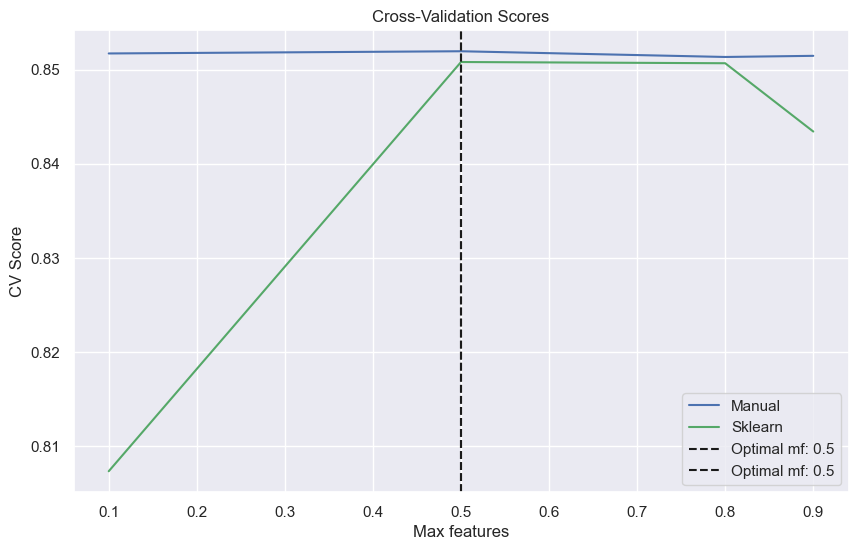

In [37]:
n_estimators = 50
sklearnn = []
manual = []
max_samples = 0.8
max_featuress = [0.1,0.5,0.8,0.9]

for max_feature in max_featuress:
    gb = Boosting_Regressor(n_estimators=n_estimators)
    gb.fit(X_train, y_train_unstd)
    gb_pred = gb.predict(X_test)
    gb_pred_train = gb.predict(X_train)
    score = evaluate_regression_metrics(y_test_unstd, y_train_unstd, gb_pred, gb_pred_train)
    manual.append(score['R² Score Test:'])

    gb = GradientBoostingRegressor(n_estimators=n_estimators,max_features=max_feature,subsample=max_samples,random_state=0)
    gb.fit(X_train, y_train_unstd)
    gb_pred = gb.predict(X_test)
    gb_pred_train = gb.predict(X_train)
    score = evaluate_regression_metrics(y_test_unstd, y_train_unstd, gb_pred, gb_pred_train)
    sklearnn.append(score['R² Score Test:'])

highest_score_manual = np.argmax(manual)
optimal_k_manual = max_featuress[highest_score_manual]

highest_score_sk = np.argmax(sklearnn)
optimal_k_sk = max_featuress[highest_score_sk]

print(f"Optimal value of mf manual: {optimal_k_manual} with a score of {manual[highest_score_manual]}")
print(f"Optimal value of mf sklearn: {optimal_k_sk} with a score of {sklearnn[highest_score_sk]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(max_featuress,manual,'b',label= 'Manual')
plt.plot(max_featuress,sklearnn,'g',label='Sklearn')
plt.axvline(x=optimal_k_manual, linestyle='--', color='k', label=f'Optimal mf: {optimal_k_manual}')
plt.axvline(x=optimal_k_sk, linestyle='--', color='k', label=f'Optimal mf: {optimal_k_sk}')

plt.title('Cross-Validation Scores')
plt.xlabel('Max features')
plt.ylabel('CV Score')
plt.legend()
plt.grid(True)
plt.show()
    

Optimal value of n_samples sklearn: 0.9 with a score of 0.8820781906565422


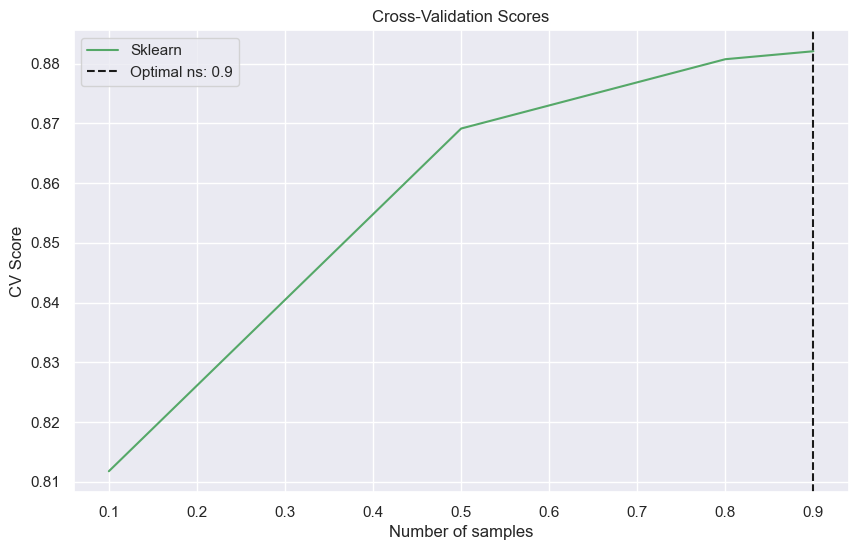

In [29]:
n_estimators = 50
sklearnn = []
max_samples = [0.1,0.5,0.8,0.9]
max_features = 0.8

# SInce my implementation doesn't have max_samples, I will do CV only on the sklearn model
for max_sample in max_samples:
    gb = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_features=max_features,
        subsample=max_sample,
        random_state=0
    )
    gb.fit(X_train, y_train_unstd)
    gb_pred = gb.predict(X_test)
    gb_pred_train = gb.predict(X_train)
    score = evaluate_regression_metrics(y_test_unstd, y_train_unstd, gb_pred, gb_pred_train)
    sklearnn.append(score['R² Score Test:'])


highest_score_sk = np.argmax(sklearnn)
optimal_k_sk = max_samples[highest_score_sk]

print(f"Optimal value of n_samples sklearn: {optimal_k_sk} with a score of {sklearnn[highest_score_sk]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(max_samples,sklearnn,'g',label='Sklearn')
plt.axvline(x=optimal_k_sk, linestyle='--', color='k', label=f'Optimal ns: {optimal_k_sk}')

plt.title('Cross-Validation Scores')
plt.xlabel('Number of samples')
plt.ylabel('CV Score')
plt.legend()
plt.grid(True)
plt.show()